In [2]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [3]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 500
batch_size = 128
F_MAP_1 = 95
F_MAP_2 = 100


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [4]:
with open('data_batch_1', 'rb') as db:
    try:
        train_samples = pickle.load(db)
    except UnicodeDecodeError:  #python 3.x
        db.seek(0)
        train_samples = pickle.load(db, encoding='latin1')

trainX, trainY = train_samples['data'], train_samples['labels']

trainX = np.array(trainX, dtype=np.float32)
trainY = np.array(trainY, dtype=np.int32)
    
trainY_ = np.zeros([trainY.shape[0], NUM_CLASSES])
trainY_[np.arange(trainY.shape[0]), trainY-1] = 1

print(trainX.shape, trainY_.shape)



(10000, 3072) (10000, 10)


In [5]:
with open('test_batch_trim', 'rb') as tb:
    try:
        test_samples = pickle.load(tb)
    except UnicodeDecodeError:  #python 3.x
        tb.seek(0)
        test_samples = pickle.load(tb, encoding='latin1')
        
testX, testY = test_samples['data'], test_samples['labels']

testX = np.array(testX, dtype=np.float32)
testY = np.array(testY, dtype=np.int32)
    
testY_ = np.zeros([testY.shape[0], NUM_CLASSES])
testY_[np.arange(testY.shape[0]), testY-1] = 1

print(testX.shape, testY_.shape)

(2000, 3072) (2000, 10)


In [6]:
trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)

 # Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

images = x
images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
#Conv 1 -- maps one RGB image (3x32x32) to 50 feature maps (50x24x24), pool to (50x12x12)
W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, F_MAP_1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
b1 = tf.Variable(tf.zeros([F_MAP_1]), name='biases_1')

conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

#Conv 2 -- maps 50 feature maps (50x12x12) to 60 (60x8x8), pool to (60x4x4)
W2 = tf.Variable(tf.truncated_normal([5, 5, F_MAP_1, F_MAP_2], stddev=1.0/np.sqrt(NUM_CHANNELS*5*5)), name='weights_2')
b2 = tf.Variable(tf.zeros([F_MAP_2]), name='biases_2')

conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1,1,1,1,], padding='VALID')+ b2)
pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

#Fully Connected Layer -- maps 60 feature maps (60x4x4) to 300 features
pool_2_shape = pool_2.get_shape().as_list()
dim = pool_2_shape[1] * pool_2_shape[2] * pool_2_shape[3]
reshape = tf.reshape(pool_2, [-1, dim])

W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
b3 = tf.Variable(tf.zeros([300]), name='biases_3')

fcon = tf.nn.relu(tf.matmul(reshape, W3) + b3)

#Softmax
W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
logits = tf.matmul(fcon, W4) + b4

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#Using RMSProp algorithm
train_step = tf.train.RMSPropOptimizer(learning_rate,0.1).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
print(N)
idx = np.arange(N)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_acc = []
    training_loss = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY_ = trainX[idx], trainY_[idx]
        
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step.run(feed_dict={x: trainX[start:end], y_: trainY_[start:end]})
            
        training_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY_}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY_}))

        print('epoch', e, 'entropy', training_loss[e], 'test accuracy', test_acc[e])
    

W1114 13:57:02.227473  9752 deprecation.py:506] From c:\python37\lib\site-packages\tensorflow\python\training\rmsprop.py:119: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


10000
epoch 0 entropy 2.0290747 test accuracy 0.2365
epoch 1 entropy 2.0178733 test accuracy 0.283
epoch 2 entropy 1.996148 test accuracy 0.2975
epoch 3 entropy 2.501658 test accuracy 0.2545
epoch 4 entropy 1.8183227 test accuracy 0.313
epoch 5 entropy 1.6164619 test accuracy 0.3955
epoch 6 entropy 1.7259301 test accuracy 0.351
epoch 7 entropy 1.8470232 test accuracy 0.3365
epoch 8 entropy 1.5970795 test accuracy 0.374
epoch 9 entropy 1.5656012 test accuracy 0.4095
epoch 10 entropy 1.6346235 test accuracy 0.3805
epoch 11 entropy 1.5824697 test accuracy 0.404
epoch 12 entropy 1.4856948 test accuracy 0.359
epoch 13 entropy 1.4830465 test accuracy 0.352
epoch 14 entropy 1.6181643 test accuracy 0.312
epoch 15 entropy 1.2737609 test accuracy 0.4085
epoch 16 entropy 1.2534037 test accuracy 0.4225
epoch 17 entropy 1.1862755 test accuracy 0.4145
epoch 18 entropy 1.4813231 test accuracy 0.385
epoch 19 entropy 1.3556796 test accuracy 0.378
epoch 20 entropy 1.0865486 test accuracy 0.4195
epoch 21

epoch 169 entropy 0.06778551 test accuracy 0.423
epoch 170 entropy 0.04975247 test accuracy 0.427
epoch 171 entropy 0.085159265 test accuracy 0.422
epoch 172 entropy 0.22598183 test accuracy 0.4245
epoch 173 entropy 0.09973198 test accuracy 0.4185
epoch 174 entropy 0.06610007 test accuracy 0.4175
epoch 175 entropy 0.13888747 test accuracy 0.423
epoch 176 entropy 0.090742186 test accuracy 0.4315
epoch 177 entropy 0.04711132 test accuracy 0.4415
epoch 178 entropy 0.13739213 test accuracy 0.428
epoch 179 entropy 0.11883832 test accuracy 0.437
epoch 180 entropy 0.079994835 test accuracy 0.445
epoch 181 entropy 0.08472212 test accuracy 0.444
epoch 182 entropy 0.09050855 test accuracy 0.4235
epoch 183 entropy 0.07883012 test accuracy 0.4065
epoch 184 entropy 0.09140647 test accuracy 0.426
epoch 185 entropy 0.055870954 test accuracy 0.432
epoch 186 entropy 0.12510815 test accuracy 0.4395
epoch 187 entropy 0.17777719 test accuracy 0.427
epoch 188 entropy 0.10346731 test accuracy 0.4395
epoch 1

epoch 335 entropy 0.038925793 test accuracy 0.4215
epoch 336 entropy 0.042429663 test accuracy 0.3995
epoch 337 entropy 0.07237788 test accuracy 0.4095
epoch 338 entropy 0.19700511 test accuracy 0.4175
epoch 339 entropy 0.11192439 test accuracy 0.408
epoch 340 entropy 0.08866638 test accuracy 0.3865
epoch 341 entropy 0.42858893 test accuracy 0.414
epoch 342 entropy 0.04516557 test accuracy 0.4295
epoch 343 entropy 0.15324004 test accuracy 0.3975
epoch 344 entropy 0.07136745 test accuracy 0.4295
epoch 345 entropy 0.055241454 test accuracy 0.438
epoch 346 entropy 0.13701883 test accuracy 0.4105
epoch 347 entropy 0.11212108 test accuracy 0.415
epoch 348 entropy 0.13165449 test accuracy 0.384
epoch 349 entropy 0.09701008 test accuracy 0.4195
epoch 350 entropy 0.25736374 test accuracy 0.3885
epoch 351 entropy 0.087197 test accuracy 0.364
epoch 352 entropy 0.028473867 test accuracy 0.4405
epoch 353 entropy 0.061253026 test accuracy 0.4125
epoch 354 entropy 0.11819911 test accuracy 0.3795
epo

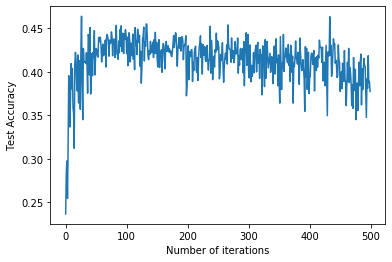

In [7]:
    plt.figure(1)
    plt.plot(range(epochs), test_acc)
    plt.ylabel('Test Accuracy')
    plt.xlabel('Number of iterations')
    plt.savefig('./A3b-Test_accuracy.png')

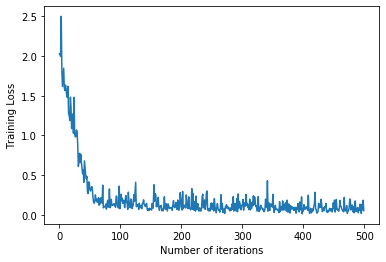

In [8]:
    plt.figure(2)
    plt.plot(range(epochs), training_loss)
    plt.xlabel('Number of iterations')
    plt.ylabel('Training Loss')
    plt.savefig('./A3b-Training_loss.png')